In [30]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in ".\rice-type-classification" (use force=True to force download)


In [31]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset    
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [32]:
data_df=pd.read_csv("rice-type-classification/riceClassification.csv")
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [33]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True)
print(f"Dataset shape: {data_df.shape}")

Dataset shape: (18185, 11)


In [34]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [35]:
print(data_df['Class'].unique())

[1 0]


In [36]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [37]:
original_df = data_df.copy()
for column in data_df.columns:
    data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [38]:
x = np.array(data_df.iloc[:, :-1])
y = np.array(data_df.iloc[:, -1])

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


In [40]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [41]:
print(x_train.shape, x_val.shape , x_test.shape)

(12729, 10) (2728, 10) (2728, 10)


In [42]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    

In [43]:
training_data= dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)
testing_data = dataset(x_test, y_test)

In [44]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=False)
testing_dataloader = DataLoader(testing_data, batch_size=32, shuffle=False)

In [45]:
HIDDEN_NEURONS = 10

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.input_layer = nn.Linear(x.shape[1], HIDDEN_NEURONS)
        self.output_layer = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x
    
model= MyModel().to(device)

In [46]:
summary(model, (x.shape[1],))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [47]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [48]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val= 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction, labels)

        total_loss_train += batch_loss.item()
        acc=((prediction).round()==labels).sum().item()
        total_acc_train += acc
        
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)
            batch_loss = criterion(prediction, labels)

            total_loss_val += batch_loss.item()
            acc = ((prediction).round() == labels).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_val_plot.append(round(total_loss_val/1000,4))
    
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__() *100,4))
    total_acc_val_plot.append(round(total_acc_val/validation_data.__len__()*100,4))

    print(f'''epoch no. {epoch + 1} Train Loss: {round(total_loss_train/1000,4)} 
          Train Accuracy {round(total_acc_train/training_data.__len__() * 100,4)} 
          Validation Loss:{round(total_loss_val/1000,4)}
          validation Accuracy:{round(total_acc_val/validation_data.__len__()*100,4)}''') 

epoch no. 1 Train Loss: 0.2458 
          Train Accuracy 78.9221 
          Validation Loss:0.0426
          validation Accuracy:97.9839
epoch no. 2 Train Loss: 0.136 
          Train Accuracy 97.5882 
          Validation Loss:0.0187
          validation Accuracy:98.0938
epoch no. 3 Train Loss: 0.0623 
          Train Accuracy 98.3581 
          Validation Loss:0.0098
          validation Accuracy:98.3504
epoch no. 4 Train Loss: 0.0379 
          Train Accuracy 98.4995 
          Validation Loss:0.0067
          validation Accuracy:98.607
epoch no. 5 Train Loss: 0.0282 
          Train Accuracy 98.5859 
          Validation Loss:0.0053
          validation Accuracy:98.4604
epoch no. 6 Train Loss: 0.0235 
          Train Accuracy 98.7666 
          Validation Loss:0.0046
          validation Accuracy:98.607
epoch no. 7 Train Loss: 0.0207 
          Train Accuracy 98.688 
          Validation Loss:0.0041
          validation Accuracy:98.7537
epoch no. 8 Train Loss: 0.0192 
          Tra

In [49]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in testing_dataloader:
        inputs,labels=data
        
        prediction = model(inputs).squeeze(1)
        batch_loss_test = criterion(prediction,labels).item()
        total_loss_test += batch_loss_test
        
        acc =((prediction).round()==labels).sum().item()
        total_acc_test += acc
        
        
print("accuracy:",round(total_acc_test/testing_data.__len__()*100,4))

accuracy: 98.3138


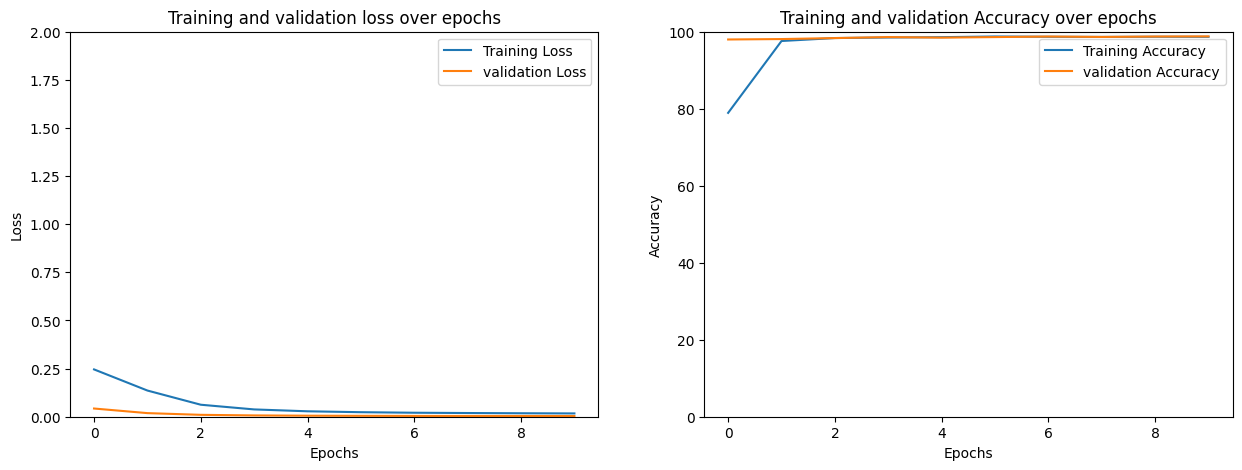

In [50]:
fig , axs = plt.subplots(nrows = 1, ncols= 2,figsize=(15,5))
axs[0].plot(total_loss_train_plot, label = 'Training Loss')
axs[0].plot(total_loss_val_plot, label = 'validation Loss')
axs[0].set_title("Training and validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = 'Training Accuracy')
axs[1].plot(total_acc_val_plot, label = 'validation Accuracy')
axs[1].set_title("Training and validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [63]:
raw_values = {
    'Area': 2353,
    'MajorAxisLength': 81,
    'MinorAxisLength': 42,
    'Eccentricity': 32,
    'ConvexArea': 12,
    'EquivDiameter': 33,
    'Extent': 98,
    'Perimeter': 927,
    'Roundness': 677,
    'AspectRation': 24
}

cols = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
        'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness', 'AspectRation']

normalized = [raw_values[c] / original_df[c].abs().max() for c in cols]

input_tensor = torch.tensor(normalized, dtype=torch.float32).to(device).unsqueeze(0)

with torch.no_grad():
    my_prediction = model(input_tensor).squeeze().cpu()

probability = my_prediction.item()
predicted_class = int(round(probability))

print("Probability:", probability)
print("Predicted class:", predicted_class)

Probability: 0.0
Predicted class: 0


In [64]:
my_prediction.item()


0.0